In [117]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from qbstyles import mpl_style

from drawdata import ScatterWidget

mpl_style()

In [85]:
def model_line(model, X, y, color_dp3d="black", color_dp2d="red", color_line2d="white", color_line3d="white", alpha=0.5):
    if X.shape[1] == 1:  # 2D Case
        plt.scatter(X.iloc[:, 0], y, marker=".", color=color_dp2d, label="Data")
        y_pred = model.predict(X).flatten()
        plt.plot(X.iloc[:, 0], y_pred, color=color_line2d, label="Model Prediction")
        plt.xlabel(X.columns[0])
        plt.ylabel(y.name)
        plt.legend()
        plt.show()

    elif X.shape[1] == 2:  # 3D Case
        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, color=color_dp3d, label="Data", marker=".")

        X_vals = X.iloc[:, 0]
        Y_vals = X.iloc[:, 1]
        Z_vals = model.predict(X).flatten()
        ax.plot_trisurf(X_vals, Y_vals, Z_vals, color=color_line3d, alpha=alpha)

        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])
        ax.set_zlabel(y.name)
        plt.legend()
        plt.show()

    else:
        raise ValueError("Only 1D or 2D features are supported.")


def predictor_line(model, X, y, dot_color="yellow", line_color="cyan", marker="."):
    pred = model.predict(X).flatten()
    y_true = y.to_numpy().flatten()
    start = min(y_true.min(), pred.min())
    end = max(y_true.max(), pred.max())
    line = np.linspace(start, end, 100)

    plt.scatter(y_true, pred, marker=marker, color=dot_color)
    plt.plot(line, line, color=line_color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()


def model_equation(model, feature_names, target_label, variable_as_name=False):
    weights = model.get_weights()
    coef = weights[0].flatten()
    intercept = weights[1][0]

    if variable_as_name:
        variables = [f"{name}" for name in feature_names]
        y = target_label
    else:
        variables = [f"x{i}" for i in range(1, len(feature_names) + 1)]
        y = "y"
        for variable, feature_name in zip(variables, feature_names):
            print(f"{variable} = {feature_name}")
        print(f"{y} = {target_label}")
    
    terms = [f"{coef[i]:.2f} * {variables[i]}" for i in range(len(coef))]
    equation = f"{y} = {terms[0]}"
    for term in terms[1:]:
        if term.startswith('-'):
            equation += f" - {term[1:]}"
        else:
            equation += f" + {term}"
    equation += f" + {intercept:.2f}" if intercept >= 0 else f" - {-intercept:.2f}"
    return equation


def loss_curve(history, color="blue"):
    plt.plot(history.history['loss'], color=color, label='Training Loss')
    plt.title('Model Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [2]:
widget = ScatterWidget()

In [3]:
widget

ScatterWidget()

In [5]:
df = widget.data_as_pandas

In [10]:
df.head()

,x,y,color,label
0,116.630274,417.804245,#1f77b4,a
1,113.815145,413.249132,#1f77b4,a
2,104.720712,412.613668,#1f77b4,a
3,117.146587,416.051495,#1f77b4,a
4,111.477001,415.201141,#1f77b4,a


<Axes: xlabel='x', ylabel='y'>

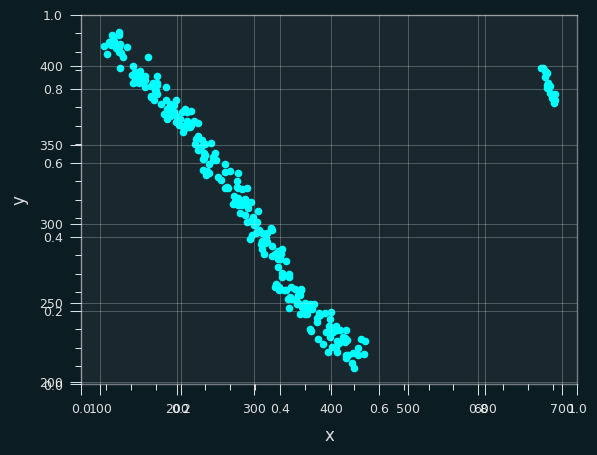

In [22]:
df.plot.scatter('x', 'y', color="cyan")

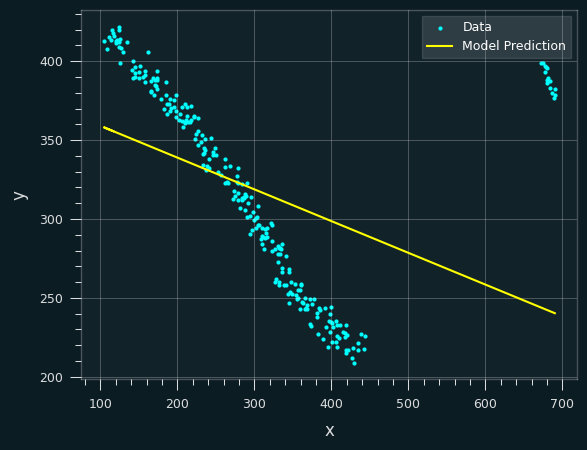

In [115]:
X = df[['x']]
y = df['y']

sklearn_model = LinearRegression()
sklearn_model.fit(X, y)

model_line(sklearn_model, X, y, color_dp2d="cyan", color_line2d="yellow")

In [121]:
X = df[['x']]
Y = df[['y']]

keras_model_mse = Sequential([
    Input(shape=(1,)),
    Dense(1, activation='linear')
], name="keras_model_mse")

keras_model_mse.compile(
    optimizer=SGD(learning_rate=0.01),
    loss='mean_squared_error'
)

keras_model_mse.summary()

Model: "keras_model_mse"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [125]:
X.describe()

,x
count,257.000000
mean,302.633355
std,132.540466
min,104.720712
25%,206.763433
50%,293.740869
75%,366.114101
max,690.128545
